In [5]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss, auc
from matplotlib import pyplot as plt
import copy

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence
from experimental_scores import probability_mass_above_given_label_score

# experimental version of label quality ensemble scores with additional weighting schemes
from label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224",
]

method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
    "magl-False": "Mass Above Given Label",
}

model_display_name_dict = {
    "swin_base_patch4_window7_224": "Swin Transformer",
    "twins_pcpvt_base": "Twins PCPVT",
    "efficientnet_b1": "EfficientNet-B1",
    "resnet50d": "ResNet-50d",
    "resnet18": "ResNet-18",
}

score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False),
    ("magl", False),
]

resnet18 -xval
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


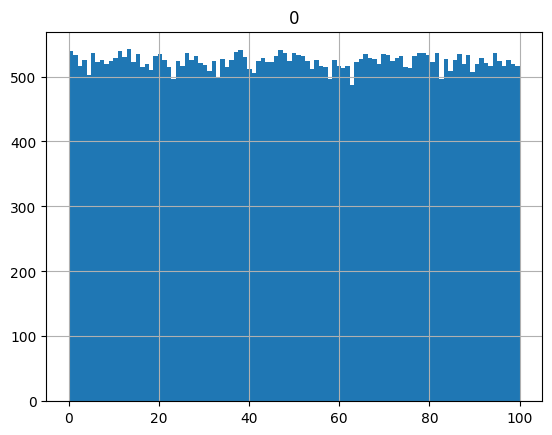

resnet50d -xval
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


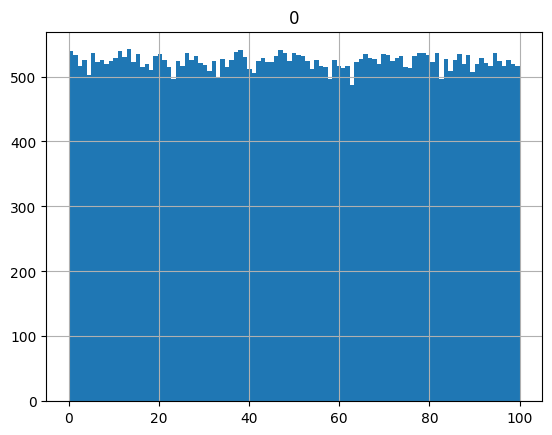

efficientnet_b1 -xval
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


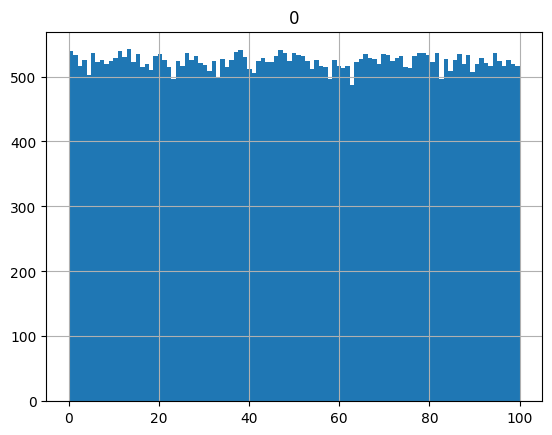

twins_pcpvt_base -xval
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


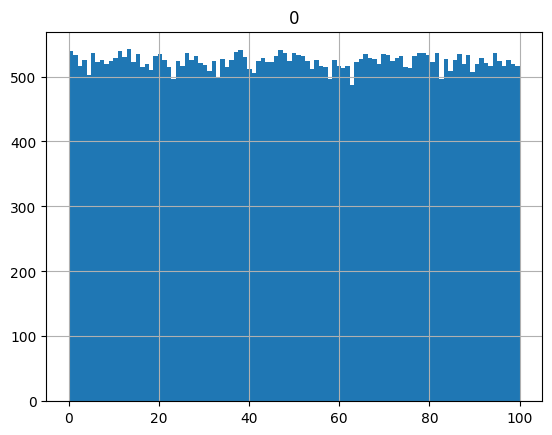

swin_base_patch4_window7_224 -xval
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


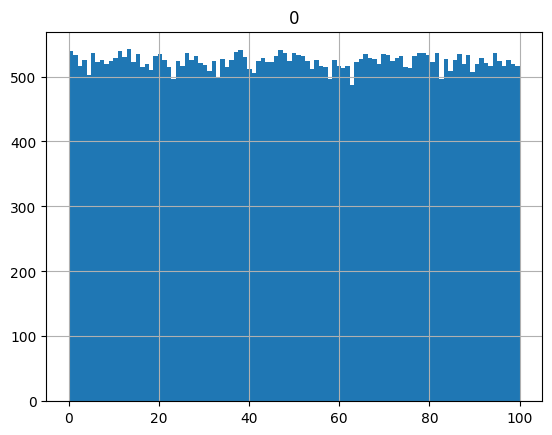

resnet18 
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


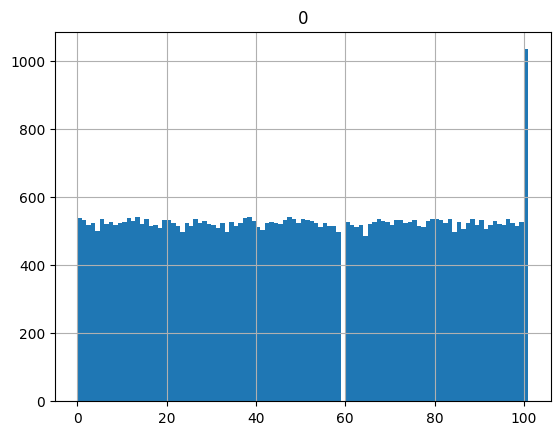

resnet50d 
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


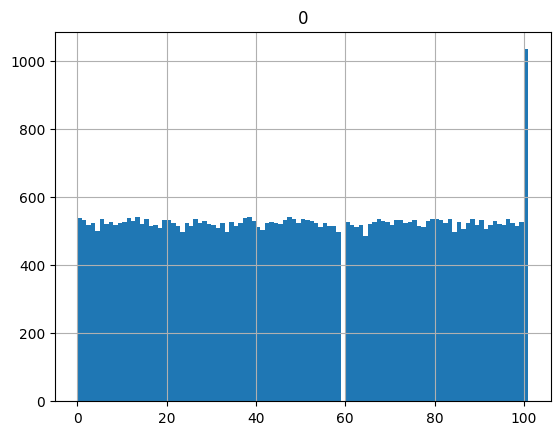

efficientnet_b1 
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


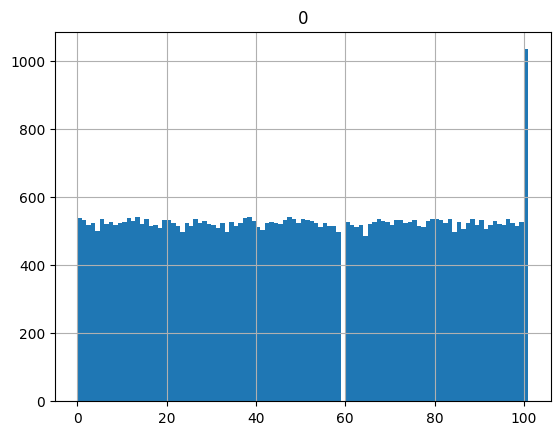

twins_pcpvt_base 
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


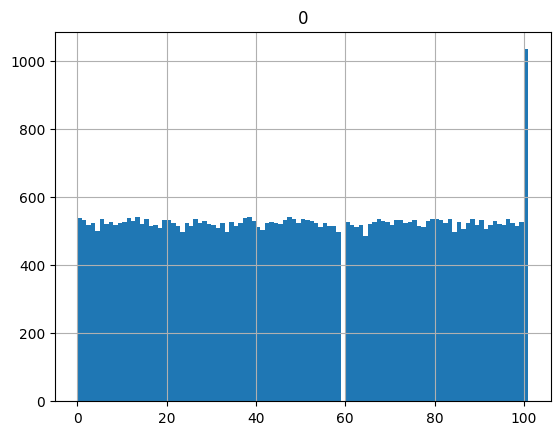

swin_base_patch4_window7_224 
label shape:  (52867,)
[[<AxesSubplot: title={'center': '0'}>]]


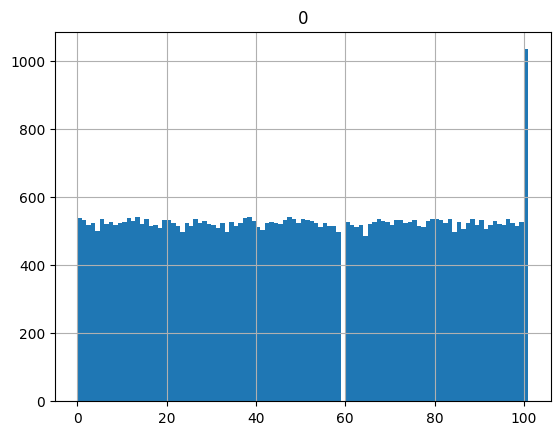

CPU times: user 23.7 s, sys: 2.41 s, total: 26.1 s
Wall time: 23.9 s


In [14]:
%%time

experiments = []
all_labels = []
all_images = []

for xval in ["-xval", ""]:
    for model in models:
        print(model, xval)
        #### Food-101n

        # we only have verified labels for ~50K images so we have to evaluate within this subset

        # read numpy files
        numpy_out_folder = f"./food-101n{xval}/food-101n_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

        # read verified training labels
#         path_verified_train = "./food-101n/verified_train.tsv"
        path_verified_train = "./verified_train.tsv"
        df_verified_train = pd.read_csv(path_verified_train, sep='\t')

        # instantiate DataFrame with all training data
        df_image_paths = pd.DataFrame({
            "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
        })

        # join to append verification_label column
        df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

        # subset of data with verified labels
        verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

        # filter on verified subset
        pred_probs = pred_probs[verified_subset_mask]
        labels = labels[verified_subset_mask]
        images = images[verified_subset_mask]

        # boolean mask of label errors
        label_errors_mask = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0

        # store results of experiment
        experiment_results = {
            "dataset": "food-101n",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask  
        }
        
        print('label shape: ', labels.shape)
        print(pd.DataFrame(labels).hist(bins=len(set(labels))))
        all_labels.append(labels)
        all_images.append(images)
        
        plt.show()
        experiments.append(experiment_results)

In [13]:
base_labels = all_labels[0]
for labels in all_labels:
    print((base_labels == labels).all())
    print(labels[5065:6000])

True
[48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48
 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48
 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 49 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 

In [25]:
base_images = all_images[0]
base_image_set = None
for images in all_images:
    print(np.sum(base_images == images))
    image_set = []
    for image in images:
        image_set.append(Path(image).parts[-2])
    image_set = set(image_set)
    if base_image_set is None:
        base_image_set = set(image_set)
    else:
        print(image_set.difference(base_image_set))
    
print(all_images[0][5065:6000])
print(all_images[-1][5065:6000])

52867
52867
set()
52867
set()
52867
set()
52867
set()
0
set()
0
set()
0
set()
0
set()
0
set()
['/Data/Food-101N_release/train/greek_salad/0fd790c64161c9fcc5df9acde99fefda.jpg'
 '/Data/Food-101N_release/train/greek_salad/1001a7f86dd150c4e3717281a0e1ec06.jpg'
 '/Data/Food-101N_release/train/greek_salad/10444efbe056f7e4835bfeb19752e8af.jpg'
 '/Data/Food-101N_release/train/greek_salad/107bcaca167dbfc61f77285b3d4b7d5a.jpg'
 '/Data/Food-101N_release/train/greek_salad/10f9d5b978cf233cde84006a9ee37d7b.jpg'
 '/Data/Food-101N_release/train/greek_salad/11d749cf4d93b638f08964a110e4a359.jpg'
 '/Data/Food-101N_release/train/greek_salad/12182beb369464f815825b731f467447.jpg'
 '/Data/Food-101N_release/train/greek_salad/123de39fd5b2c67280793600c668f649.jpg'
 '/Data/Food-101N_release/train/greek_salad/123f6d9662487334f8200d73423b6164.jpg'
 '/Data/Food-101N_release/train/greek_salad/12590d961ccdb84245bffd726a829eb3.jpg'
 '/Data/Food-101N_release/train/greek_salad/125b9eee7f6165bcfaeb845d7fb144f0.jpg'
 '/D

In [27]:
# Run noisy labels
classes = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'images',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']
xval_classes = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']
print(len(classes), len(xval_classes))
print(set(classes).difference(set(xval_classes)))

102 101
{'images'}


In [ ]:
for experiment in experiments:
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    
    accuracy = {
        "dataset": dataset,
        "model": model,
        "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
    }
    
    accuracy_list.append(accuracy)
    
    RESNET_18_FOOD_labels = None
    for score_param in score_params:        
        # compute scoring method
        method, adjust_pred_probs = score_param
        print(dataset, model, method, adjust_pred_probs)
        if dataset == 'food-101n':
            RESNET_18_FOOD_labels = labels
            print(labels.shape, pred_probs.shape, adjust_pred_probs)
            print('testing error')
            print(list(enumerate(labels))[-10:])
            print(len(set(labels)), len(labels))
            print(min(labels), max(labels))
            print(type(labels))
            print(pd.DataFrame(labels).describe())
            print(pd.DataFrame(labels).hist(bins=len(set(labels))))
            plt.show()

In [ ]:
food-101n_cv_efficientnet_b1